In [1]:
from model import Network
from data import load_mnist_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_mnist_instance.json'
checkpoint_path = './checkpoints/122223_fc2_cocktail_party_mnist_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_mnist_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([128, 784]), torch.Size([10, 128])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(28, 28, 1, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.2811412811279297
loss: 1.1188737154006958
loss: 1.068575382232666
loss: 1.0424059629440308
loss: 1.027836799621582
loss: 1.0188182592391968
loss: 1.0122301578521729
loss: 1.0075979232788086
loss: 1.0037399530410767
loss: 1.001481056213379
loss: 1.0005477666854858
loss: 1.000411033630371
loss: 1.0004923343658447
loss: 1.0005451440811157
loss: 1.0005789995193481
loss: 1.0004156827926636
loss: 1.0003869533538818
loss: 1.0005403757095337
loss: 1.0003644227981567
loss: 1.0007047653198242
loss: 1.000399112701416
loss: 1.0003423690795898
loss: 1.0004998445510864
loss: 1.0004032850265503
loss: 1.0004643201828003
loss: 1.000467300415039


## Estimated images

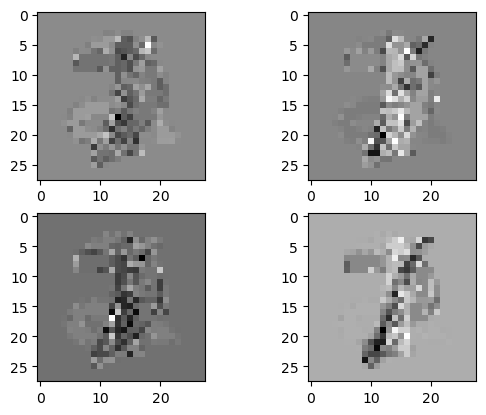

In [13]:
with torch.no_grad():
    unmixing_matrix = unmixing_matrix.detach().to('cpu')
    whitened_gradient = whitened_gradient.detach().to('cpu')
    estimated_img = unmixing_matrix @ whitened_gradient

    fig, axes = plt.subplots(2, 2)

    for estimate, ax in zip(estimated_img, axes.flatten()):
        img = np.squeeze(colors.Normalize()(np.asarray(estimate)).reshape(1, 28, 28).transpose(1, 2, 0))
        ax.imshow(img, cmap='gray')
    plt.show()

## Original images

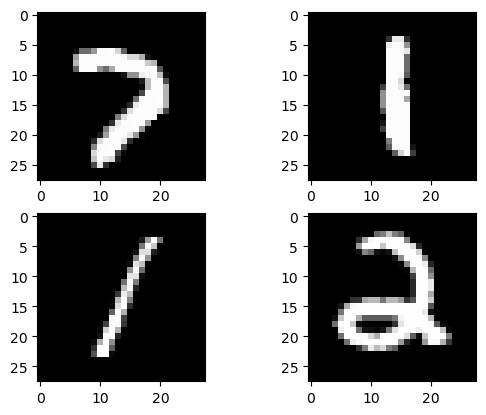

In [8]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(1, 28, 28))
        img = np.asarray(img)
        ax.imshow(img, cmap='gray')
    plt.show()